# CEEL82B Expt 7: Text Analysis

### Objective:
Separating Spam From Ham
1. Build and evaluate spam filter using publicly available dataset.
2. Prepare the corpus by performing various data preprocessing such as converting to lowercase, removing punctuations, stopwords, tokenization.
3. Build ML models like Random Forest and CART on this document term matrix.
4. Compare the results of both the models.

In [46]:
import re
import pandas as pd
import numpy as np
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, auc, accuracy_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns    
import matplotlib.pyplot as plt
%matplotlib inline 

### Problem 1.1 - Loading the dataset

In [4]:
emails = pd.read_csv('emails.csv')
n = emails.count()[0]
emails.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


**Q1. How many emails are in the dataset?**

5728 emails are present in the dataset

In [5]:
emails.describe()

,spam
count,5728.000000
mean,0.238827
std,0.426404
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


**Q2. How many of the emails are spam?**

There are 1368 spam emails, roughly 24% of the dataset is spam and rest are ham datapoints, as seen by the mean, as well as the countplot of the spam column

The dataset has 1368 spam emails out of 5728, roughly 23.88%


C:\Users\aurko\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


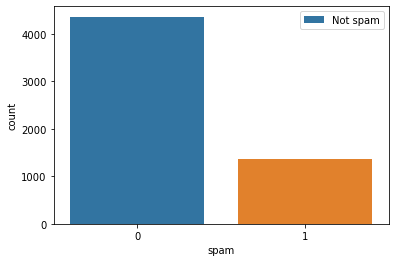

In [6]:
sns.countplot(emails['spam'])
plt.legend(['Not spam', 'Spam'])
nspam=emails.query('spam == 1').count()[0]
print(f"The dataset has {nspam} spam emails out of {emails.count()[0]}, roughly 23.88%")

There are total 2 columns, text is of string type and spam is of int type each containing the content of the email and it's status, if it's spam or ham

In [7]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


**Q3. Which word appears at the beginning of every email in the dataset?**

Subject

In [8]:
emails['text']

0       Subject: naturally irresistible your corporate...
1       Subject: the stock trading gunslinger  fanny i...
2       Subject: unbelievable new homes made easy  im ...
3       Subject: 4 color printing special  request add...
4       Subject: do not have money , get software cds ...
                              ...                        
5723    Subject: re : research and development charges...
5724    Subject: re : receipts from visit  jim ,  than...
5725    Subject: re : enron case study update  wow ! a...
5726    Subject: re : interest  david ,  please , call...
5727    Subject: news : aurora 5 . 2 update  aurora ve...
Name: text, Length: 5728, dtype: object

In [9]:
print(f"Checking if all the emails contain first word as `Subject:`")
emails[emails['text'].apply(lambda x: x.startswith('Subject:'))].count()[0]
print("We see that all the emails contain the word subject")

Checking if all the emails contain first word as `Subject:`
We see that all the emails contain the word subject


**Q4. Could a spam classifier potentially benefit from including the frequency of the word that appears in every email?**

**Current Hypothesis**

Since all emails have a subject, including the frequency of the word appearing in every email would not give us any useful information about the nature of the email/ it's contents that contain the spam, and should hence be removed

**No** : The word appears in every email so this variable would not help us differentiate spam from ham.

**Q5. How many characters are in the longest email in the dataset (where longest is measured in terms of the maximum number of characters)?**

43952

C:\Users\aurko\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


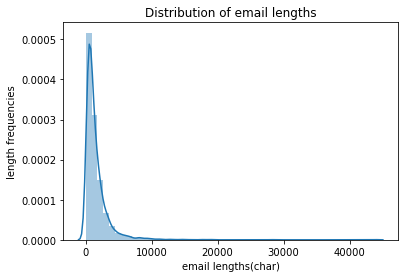

In [10]:
subject_len = emails.apply(lambda x: len(x['text']), axis=1)
sns.distplot(subject_len)
plt.title('Distribution of email lengths')
plt.xlabel('email lengths(char)')
plt.ylabel('length frequencies')
plt.show()

In [11]:
print(f'The maximum email length is {max(subject_len)}')

The maximum email length is 43952


### Problem 2.1 - Preparing the corpus

Before proceeding, we make changes to the original text column of the dataset:
* Remove all the punctutaions 
* Make our 'text' column into lowercase
* Remove the stopwords
* Apply Stemming on the corpus

### a. Remove Punctuations

In [12]:
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
def fn(text):
    # Removing punctuations in stripped and lowercased string using regex
    return re.sub(r'[^\w\s]', '', text.strip()[8:].lower())

emails['text'] = emails['text'].apply(func=fn)
emails.head()

,text,spam
0,naturally irresistible your corporate identit...,1
1,the stock trading gunslinger fanny is merril...,1
2,unbelievable new homes made easy im wanting ...,1
3,4 color printing special request additional ...,1
4,do not have money get software cds from here...,1


In [15]:
with open('stopwords.txt') as f:
    exec(f.read())
sw

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 "can't",
 'cannot',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 "let's",
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'same',
 "shan't",
 'she',
 "she'd",
 "she'll",
 "she's",
 'should',
 "s

### b. Remove Stopwords

In [16]:
def remove_stopwords(text):
    temp = ''
    for word in text.split():
        if word not in sw:
            temp += (word+' ')
    return temp.strip()
emails['text']=emails['text'].apply(remove_stopwords)
emails.head()

,text,spam
0,naturally irresistible corporate identity lt r...,1
1,stock trading gunslinger fanny merrill muzo co...,1
2,unbelievable new homes made easy im wanting sh...,1
3,4 color printing special request additional in...,1
4,money get software cds software compatibility ...,1


### c. Stemming

In [17]:
snowball = SnowballStemmer(language='english')
def stem(text):
    temp = ''
    for word in text.split():
        temp += ( snowball.stem(word) + ' ' )
    return temp.strip()
emails['text']=emails['text'].apply(stem) # Apply stemming to the text
emails.head()

,text,spam
0,natur irresist corpor ident lt realli hard rec...,1
1,stock trade gunsling fanni merril muzo colza a...,1
2,unbeliev new home made easi im want show homeo...,1
3,4 color print special request addit inform now...,1
4,money get softwar cds softwar compat ain t gre...,1


### Building DTM & corpus

In [30]:
cv = CountVectorizer()
dtm = cv.fit_transform(emails['text'])

In [31]:
dtm.shape

(5728, 29266)

There are 29266 terms in document matrix

### Creating spdtm (atleast 5% doc terms)
Limiting dtm to contain terms appearing in at least 5% of documents

In [32]:
cv_sp = CountVectorizer(max_df = 0.05)
spdtm = cv_sp.fit_transform(emails['text'])
spdtm.shape

(5728, 28892)

There are 28892 terms in spdtm

### Problem 3.1 – Building machine learning models

In [36]:
X = spdtm
y = np.array(emails['spam']).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(f'There are {len(list(X_train))} items in train and {len(list(X_test))} items in test')

There are 4009 items in train and 1719 items in test


### CART model
Training the CART model

In [42]:
spamCART = DecisionTreeClassifier(criterion="gini")
spamCART.fit(X_train, y_train)

DecisionTreeClassifier()

### Random Forest model
Training the CART model

In [50]:
spamRF = RandomForestClassifier()
spamRF.fit(X_train, y_train)

<ipython-input-50-1dd573f5ac03>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  spamRF.fit(X_train, y_train)


RandomForestClassifier()

#### What is the training set accuracy of spamCART ?

In [51]:
y_train_cart = spamCART.predict(X_train.toarray())
print(f'Accuracy(CART) on training data: {accuracy_score(y_train, y_train_cart)}')

Accuracy(CART) on training data: 1.0


#### What is the training set AUC of spamCART ?

In [52]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_cart)
print(f'AUC(CART) on training data: {auc(fpr, tpr)}')

AUC(CART) on training data: 1.0


#### What is the training set accuracy of spamRF ?

In [53]:
y_train_rf = spamRF.predict(X_train.toarray())
print(f'Accuracy(RF) on training data: {accuracy_score(y_train, y_train_rf)}')

Accuracy(RF) on training data: 1.0


#### What is the training set AUC of spamRF ?

In [54]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_rf)
print(f'AUC(RF) on training data: {auc(fpr, tpr)}')

AUC(RF) on training data: 1.0


### Problem 4.1 – Evaluating on the Test Set

#### What is the testing set accuracy of spamCART ?

In [55]:
y_test_cart = spamCART.predict(X_test.toarray())
print(f'Accuracy on training data: {accuracy_score(y_test, y_test_cart)}')

Accuracy on training data: 0.9232111692844677


#### What is the testing set AUC of spamCART ?

In [56]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_cart)
print(f'AUC on training data: {auc(fpr, tpr)}')

AUC on training data: 0.8930612898633257


In [65]:
print(classification_report(y_test, y_test_cart))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1280
           1       0.86      0.83      0.85       439

    accuracy                           0.92      1719
   macro avg       0.90      0.89      0.90      1719
weighted avg       0.92      0.92      0.92      1719



#### What is the testing set accuracy of spamRF ?

In [57]:
y_test_rf = spamRF.predict(X_test.toarray())
print(f'Accuracy on training data: {accuracy_score(y_test, y_test_rf)}')

Accuracy on training data: 0.956369982547993


#### What is the testing set AUC of spamRF ?

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_rf)
print(f'AUC on training data: {auc(fpr, tpr)}')

AUC on training data: 0.9235585136674259


In [64]:
print(classification_report(y_test, y_test_rf))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1280
           1       0.97      0.86      0.91       439

    accuracy                           0.96      1719
   macro avg       0.96      0.92      0.94      1719
weighted avg       0.96      0.96      0.96      1719



### Which model had the best testing set performance, in terms of accuracy and AUC? 

Comparing ROC and accuracy scores 

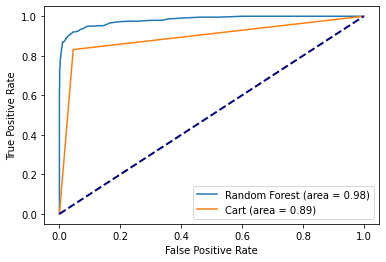

,Model,Testing Accuracy
0,CART,92.321117
1,Random Forest,95.636998


In [62]:
y_pred_proba_rf = spamRF.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_rf)
roc_auc = auc(fpr, tpr)

#create ROC curve
plt.plot(fpr,tpr, label='Random Forest (area = %0.2f)' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

y_pred_proba_cart = spamCART.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_cart)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr, label='Cart (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1],color="navy",lw=2,linestyle="--")


plt.legend()
plt.show()

pd.DataFrame([['CART',(accuracy_score(y_test, y_test_cart) * 100)],
              ['Random Forest', (accuracy_score(y_test, y_test_rf) * 100)]],
             columns=['Model','Testing Accuracy'])

### Conclusion:
1. We first observed that there are 1368 spam emails, roughly 24% of the dataset is spam and rest are ham data. We observed that all the emails had their first word as subject, and established that it's frequency in an email doesn't have any significant influence on the decision of it being spam or ham.
2. Then the corpus was prepared and all the words were pooled in after the sentences were stemmed, lowercased, stopwords were removed etc. Subsequently from the corpus, dtm was formed and each sentence was transformed into a vector. We found that it was better to form a spdtm, limiting dtm to contain terms appearing in at least 5% of documents.
3. CART model, i.e. DecisionTreeClassifier with gini criteria, vs RandomForestClassifier were built, and their training and testing accuracies and AUC's were measured, in which both gave excellent training accuracy/AUC score, but RandomForest performed better in testing accuracy/AUC both. And uniformly performed better in terms of precision, recall and f1 score. Thus the best among the 2 mdoels is RandomForest as it is able to take the best output out of multiple trees. 